# Check convergence of messages
For each message $\mu$ at iteration $t$, compute $\sum_x \left|\mu^{(t)}(x)-\mu^{(t-1)}(x)\right|$ and check that it goes to zero

## Infinite graph

In [11]:
using MatrixProductBP, MatrixProductBP.Models, TensorTrains
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using LaTeXStrings;

In [5]:
T = 5         # final time
k = 3          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.2
h = 0.0;

In [13]:
function CB(bp)
    cb = CB_BP(bp)
    aux = deepcopy(bp.μ)
    matrixdiff = []
    function cb_matrixconvergence(bp, it, svd_trunc)
        Δ = cb(bp, it, svd_trunc)
        diff = [norm(A)^2 + norm(B)^2 - 2*trABt(A, B) for (A, B) in zip(bp.μ, aux)]
        push!(matrixdiff, diff)
        aux = deepcopy(bp.μ)
        Δ
    end
    cb, cb_matrixconvergence, matrixdiff
end

CB (generic function with 1 method)

In [14]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ);

In [15]:
cb, cb2, matrixdiff = CB(bp)
iters, cb2 = iterate!(bp, maxiter=20; svd_trunc = TruncBond(3), cb=cb2, tol=1e-10, damp=0.5);

Running MPBP: iter 18 	 Time: 0:00:00
  Δ:                2.5976643058811533e-10
  SVD Matrix size:  3

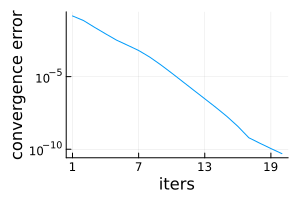

In [16]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [17]:
matrixdiff

20-element Vector{Any}:
 [5.3559776117197535e-5]
 [6.1742960092061455e-6]
 [7.97575885065193e-7]
 [1.0718649570218633e-7]
 [1.8284576417510433e-8]
 [3.3450507953836084e-9]
 [5.32462136122909e-10]
 [6.508115888651661e-11]
 [6.211345131811041e-12]
 [4.971239348991463e-13]
 [3.587939407384555e-14]
 [2.467860985011505e-15]
 [1.6620819304202783e-16]
 [1.1058862159352145e-17]
 [8.673617379884035e-19]
 [0.0]
 [0.0]
 [-1.0842021724855044e-19]
 [0.0]
 [-2.168404344971009e-19]

## Finite graph

In [18]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, LaTeXStrings 
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using Graphs, IndexedGraphs

In [19]:
T = 5
k = 3
N = 10^2
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N));

In [20]:
cb, cb2, matrixdiff = CB(bp)
iters, cb2 = iterate!(bp, maxiter=20; svd_trunc = TruncBond(3), cb=cb2, tol=1e-10, damp=0.5);

Running MPBP: iter 20 	 Time: 0:00:10
  Δ:                6.191450391934694e-6
  SVD Matrix size:  3

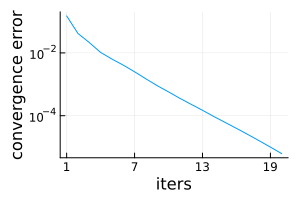

In [21]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [22]:
maximum.(matrixdiff)

20-element Vector{Float64}:
 1.7841632004015197e-5
 5.649008393423258e-6
 1.8679374727034303e-6
 7.056514738466987e-7
 2.8384286439200705e-7
 1.1545740147462808e-7
 4.716203610261559e-8
 1.9273820268733352e-8
 7.871356610348462e-9
 3.210150974469056e-9
 1.3062143097838583e-9
 5.297137976737268e-10
 2.138343260056283e-10
 8.582135598966117e-11
 3.420694164122523e-11
 1.3527857978777591e-11
 5.3042515041692995e-12
 2.0609844126467936e-12
 7.933048749159122e-13
 3.0244958013764256e-13